In [ ]:
!pip install tensorboardX
from tensorboardX import SummaryWriter
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Categorical


!pip install gym[classic_control]
!pip install gym[box2d] #for lunarlander
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper
import gnwrapper
!nvidia-smi
print(torch.cuda.is_available())

In [ ]:
## For linear lr decay
## https://github.com/cmpark0126/pytorch-polynomial-lr-decay
! pip install git+https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git
from torch_poly_lr_decay import PolynomialLRDecay

In [ ]:
class Representation(nn.Module): 
    """Representation Network

    Representation network produces hidden state from observations.
    Hidden state scaled within the bounds of [-1,1]. 
    Simple mlp network used with 1 skip connection.

    input : raw input
    output : hs(hidden state) 
    """
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.skip = torch.nn.Linear(input_dim, output_dim)  
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width)
        self.layer3 = torch.nn.Linear(width, width) 
        self.layer4 = torch.nn.Linear(width, width)  
        self.layer5 = torch.nn.Linear(width, output_dim)     
        
    def forward(self, x):
        s = self.skip(x)
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        x = torch.nn.functional.relu(x)
        x = self.layer4(x)
        x = torch.nn.functional.relu(x)
        x = self.layer5(x)    
        x = torch.nn.functional.relu(x+s)
        x = 2*(x - x.min(-1,keepdim=True)[0])/(x.max(-1,keepdim=True)[0] - x.min(-1,keepdim=True)[0])-1 
        return x


class Dynamics(nn.Module): 
    """Dynamics Network

    Dynamics network transits (hidden state + action) to next hidden state and inferences reward model.
    Hidden state scaled within the bounds of [-1,1]. Action encoded to one-hot representation. 
    Zeros tensor is used for action -1.
    
    Output of the reward head is categorical representation, instaed of scalar value.
    Categorical output will be converted to scalar value with 'to_scalar()',and when 
    traning target value will be converted to categorical target with 'to_cr()'.
    
    input : hs, action
    output : next_hs, reward 
    """
    def __init__(self, input_dim, output_dim, width, action_space):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim + action_space, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.hs_head = torch.nn.Linear(width, output_dim)
        self.reward_head = nn.Sequential(
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,support_size*2+1)           
        ) 
        self.one_hot_act = torch.cat((F.one_hot(torch.arange(0, action_space) % action_space, num_classes=action_space),
                                      torch.zeros(action_space).unsqueeze(0)),
                                      dim=0).to(device)        
       
    def forward(self, x, action):
        action = self.one_hot_act[action.squeeze(1)]
        x = torch.cat((x,action.to(device)), dim=1)
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        hs = self.hs_head(x)
        hs = torch.nn.functional.relu(hs)
        reward = self.reward_head(x)    
        hs = 2*(hs - hs.min(-1,keepdim=True)[0])/(hs.max(-1,keepdim=True)[0] - hs.min(-1,keepdim=True)[0])-1
        return hs, reward


class Prediction(nn.Module): 
    """Prediction Network

    Prediction network inferences probability distribution of policy and value model from hidden state. 

    Output of the value head is categorical representation, instaed of scalar value.
    Categorical output will be converted to scalar value with 'to_scalar()',and when 
    traning target value will be converted to categorical target with 'to_cr()'.
        
    input : hs
    output : P, V 
    """
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.policy_head = nn.Sequential(
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,output_dim)           
        ) 
        self.value_head = nn.Sequential(
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,support_size*2+1)           
        ) 
   
    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        P = self.policy_head(x)
        P = torch.nn.functional.softmax(P, dim=-1) 
        V = self.value_head(x)      
        return P, V


"""
For categorical representation
reference : https://github.com/werner-duvaud/muzero-general
In my opinion, support size have to cover the range of maximum absolute value of 
reward and value of entire trajectories. Support_size 30 can cover almost [-900,900].
"""
support_size = 30
eps = 0.001

def to_scalar(x):
    x = torch.softmax(x, dim=-1)
    probabilities = x
    support = (torch.tensor([x for x in range(-support_size, support_size + 1)]).expand(probabilities.shape).float().to(device))
    x = torch.sum(support * probabilities, dim=1, keepdim=True)
    scalar = torch.sign(x) * (((torch.sqrt(1 + 4 * eps * (torch.abs(x) + 1 + eps)) - 1) / (2 * eps))** 2 - 1)
    return scalar

def to_scalar_no_soft(x): ## test purpose
    probabilities = x 
    support = (torch.tensor([x for x in range(-support_size, support_size + 1)]).expand(probabilities.shape).float().to(device))
    x = torch.sum(support * probabilities, dim=1, keepdim=True)
    scalar = torch.sign(x) * (((torch.sqrt(1 + 4 * eps * (torch.abs(x) + 1 + eps)) - 1) / (2 * eps))** 2 - 1)
    return scalar

def to_cr(x):
    x = x.squeeze(-1).unsqueeze(0)
    x = torch.sign(x) * (torch.sqrt(torch.abs(x) + 1) - 1) + eps * x
    x = torch.clip(x, -support_size, support_size)
    floor = x.floor()
    under = x - floor
    floor_prob = (1 - under)
    under_prob = under
    floor_index = floor + support_size
    under_index = floor + support_size + 1
    logits = torch.zeros(x.shape[0], x.shape[1], 2 * support_size + 1).type(torch.float32).to(device)
    logits.scatter_(2, floor_index.long().unsqueeze(-1), floor_prob.unsqueeze(-1))
    under_prob = under_prob.masked_fill_(2 * support_size < under_index, 0.0)
    under_index = under_index.masked_fill_(2 * support_size < under_index, 0.0)
    logits.scatter_(2, under_index.long().unsqueeze(-1), under_prob.unsqueeze(-1))
    return logits.squeeze(0)


##Target network
class Target(nn.Module):
    """Target Network
    
    Target network is used to approximate v_pi_prior, q_pi_prior, pi_prior.
    It contains older network parameters. (exponential moving average update)
    """
    def __init__(self, state_dim, action_dim, width):
        super().__init__()
        self.representation_network = Representation(state_dim*8, state_dim*4, width) 
        self.dynamics_network = Dynamics(state_dim*4, state_dim*4, width, action_dim)
        self.prediction_network = Prediction(state_dim*4, action_dim, width) 
        self.to(device)

##Muesli agent
class Agent(nn.Module):
    """Agent Class"""
    def __init__(self, state_dim, action_dim, width):
        super().__init__()
        self.representation_network = Representation(state_dim*8, state_dim*4, width) 
        self.dynamics_network = Dynamics(state_dim*4, state_dim*4, width, action_dim)
        self.prediction_network = Prediction(state_dim*4, action_dim, width) 
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.00032, weight_decay=0)
        self.scheduler = PolynomialLRDecay(self.optimizer, max_decay_steps=4000, end_learning_rate=0.0000)   
        self.to(device)

        self.state_traj = []
        self.action_traj = []
        self.P_traj = []
        self.r_traj = []      

        self.state_replay = []
        self.action_replay = []
        self.P_replay = []
        self.r_replay = []   

        self.action_space = action_dim
        self.env = gym.make(game_name)     

        self.var = 0
        self.beta_product = 1.0

        self.var_m = [0 for _ in range(5)]
        self.beta_product_m = [1.0 for _ in range(5)] 


    def self_play_mu(self, max_timestep=10000):        
        """Self-play and save trajectory to replay buffer

        (Originally target network used to inference policy, but i used agent network instead)

        Eight previous observations stacked -> representation network -> prediction network 
        -> sampling action follow policy -> next env step
        """      
        game_score = 0
        state = self.env.reset()
        state_dim = len(state)
        for i in range(max_timestep):   
            start_state = state
            if i == 0:
                stacked_state = np.concatenate((state, state, state, state, state, state, state, state), axis=0)
            else:
                stacked_state = np.roll(stacked_state,-state_dim,axis=0)                
                stacked_state[-state_dim:]=state

            with torch.no_grad():
                hs = self.representation_network(torch.from_numpy(stacked_state).float().to(device))
                P, v = self.prediction_network(hs)    
            action = np.random.choice(np.arange(self.action_space), p=P.detach().cpu().numpy())   
            state, r, done, info = self.env.step(action)                    
            
            if i == 0:
                for _ in range(8):
                    self.state_traj.append(start_state)
            else:
                self.state_traj.append(start_state)
            self.action_traj.append(action)
            self.P_traj.append(P.cpu().numpy())
            self.r_traj.append(r)

            game_score += r

            ## For fix lunarlander-v2 env does not return reward -100 when 'TimeLimit.truncated'
            if done:
                if (info['TimeLimit.truncated'] == True) and abs(r)!=100:
                    game_score -= 100
                    self.r_traj[-1] = -100
                    r = -100
                last_frame = i
                break

        #print('self_play: score, r, done, info, lastframe', int(game_score), r, done, info, i)


        # for update inference over trajectory length
        for _ in range(5):
            self.state_traj.append(np.zeros_like(state))

        for _ in range(6):
            self.r_traj.append(0.0)
            self.action_traj.append(-1)  

        # traj append to replay
        self.state_replay.append(self.state_traj)
        self.action_replay.append(self.action_traj)
        self.P_replay.append(self.P_traj)
        self.r_replay.append(self.r_traj)  

        writer.add_scalars('Selfplay',
                           {'lastreward': r,
                            'lastframe': last_frame+1
                           },global_i)

        return game_score , r, last_frame


    def update_weights_mu(self, target):
        """Optimize network weights.

        Iteration: 20
        Mini-batch size: 16 (4 replay, 4 seqeuences in 1 replay)
        Replay: Uniform replay without on-policy data
        Discount: 0.997
        Unroll: 5 step
        L_m: 5 step(Muesli)
        Observations: Stack 8 frame
        regularizer_multiplier: 5 
        Loss: L_pg_cmpo + L_v/6/4 + L_r/5/1 + L_m
        """

        for _ in range(20): 
            state_traj = []
            action_traj = []
            P_traj = []
            r_traj = []      
            G_arr_mb = []

            for epi_sel in range(4):
                if(epi_sel>-1):## replay proportion
                    sel = np.random.randint(0,len(self.state_replay)) 
                else:
                    sel = -1

                ## multi step return G (orignally retrace used)
                G = 0
                G_arr = []
                for r in self.r_replay[sel][::-1]:
                    G = 0.997 * G + r
                    G_arr.append(G)
                G_arr.reverse()
                
                for i in np.random.randint(len(self.state_replay[sel])-5-7,size=4):
                    state_traj.append(self.state_replay[sel][i:i+13])
                    action_traj.append(self.action_replay[sel][i:i+5])
                    r_traj.append(self.r_replay[sel][i:i+5])
                    G_arr_mb.append(G_arr[i:i+6])                        
                    P_traj.append(self.P_replay[sel][i])


            state_traj = torch.from_numpy(np.array(state_traj)).to(device)
            action_traj = torch.from_numpy(np.array(action_traj)).unsqueeze(2).to(device)
            P_traj = torch.from_numpy(np.array(P_traj)).to(device)
            G_arr_mb = torch.from_numpy(np.array(G_arr_mb)).unsqueeze(2).float().to(device)
            r_traj = torch.from_numpy(np.array(r_traj)).unsqueeze(2).float().to(device)
            inferenced_P_arr = []

            ## stacking 8 frame
            stacked_state_0 = torch.cat((state_traj[:,0], state_traj[:,1], state_traj[:,2], state_traj[:,3],
                                         state_traj[:,4], state_traj[:,5], state_traj[:,6], state_traj[:,7]), dim=1)


            ## agent network inference (5 step unroll)
            first_hs = self.representation_network(stacked_state_0)
            first_P, first_v_logits = self.prediction_network(first_hs)      
            inferenced_P_arr.append(first_P)

            second_hs, r_logits = self.dynamics_network(first_hs, action_traj[:,0])    
            second_P, second_v_logits = self.prediction_network(second_hs)
            inferenced_P_arr.append(second_P)

            third_hs, r2_logits = self.dynamics_network(second_hs, action_traj[:,1])    
            third_P, third_v_logits = self.prediction_network(third_hs)
            inferenced_P_arr.append(third_P)

            fourth_hs, r3_logits = self.dynamics_network(third_hs, action_traj[:,2])    
            fourth_P, fourth_v_logits = self.prediction_network(fourth_hs)
            inferenced_P_arr.append(fourth_P)

            fifth_hs, r4_logits = self.dynamics_network(fourth_hs, action_traj[:,3])    
            fifth_P, fifth_v_logits = self.prediction_network(fifth_hs)
            inferenced_P_arr.append(fifth_P)

            sixth_hs, r5_logits = self.dynamics_network(fifth_hs, action_traj[:,4])    
            sixth_P, sixth_v_logits = self.prediction_network(sixth_hs)
            inferenced_P_arr.append(sixth_P)


            ## target network inference
            with torch.no_grad():
                t_first_hs = target.representation_network(stacked_state_0)
                t_first_P, t_first_v_logits = target.prediction_network(t_first_hs)  


            ## normalized advantage
            beta_var = 0.99
            self.var = beta_var*self.var + (1-beta_var)*(torch.sum((G_arr_mb[:,0] - to_scalar(t_first_v_logits))**2)/16)
            self.beta_product *= beta_var
            var_hat = self.var/(1-self.beta_product)
            under = torch.sqrt(var_hat + 1e-12)


            ## L_pg_cmpo first term (eq.10)
            importance_weight = torch.clip(first_P.gather(1,action_traj[:,0])
                                        /(P_traj.gather(1,action_traj[:,0])),
                                        0, 1
            )
            first_term = -1 * importance_weight * (G_arr_mb[:,0] - to_scalar(t_first_v_logits))/under


            ##lookahead inferences (one step look-ahead to some actions to estimate q_prior, from target network)
            with torch.no_grad():                                
                r1_arr = []
                v1_arr = []
                a1_arr = []
                for _ in range(self.action_space): #sample <= N(action space), now N    
                    action1_stack = []
                    for p in t_first_P:             
                        action1_stack.append(np.random.choice(np.arange(self.action_space), p=p.detach().cpu().numpy()))    
                    hs, r1 = target.dynamics_network(t_first_hs, torch.unsqueeze(torch.tensor(action1_stack),1))
                    _, v1 = target.prediction_network(hs)

                    r1_arr.append(to_scalar(r1))
                    v1_arr.append(to_scalar(v1) )
                    a1_arr.append(torch.tensor(action1_stack))               

            ## z_cmpo_arr (eq.12)
            with torch.no_grad():   
                exp_clip_adv_arr = [torch.exp(torch.clip((r1_arr[k] + 0.997 * v1_arr[k] - to_scalar(t_first_v_logits))/under, -1, 1))
                                    .tolist() for k in range(self.action_space)]
                exp_clip_adv_arr = torch.tensor(exp_clip_adv_arr).to(device)
                z_cmpo_arr = []
                for k in range(self.action_space):
                    z_cmpo = (1 + torch.sum(exp_clip_adv_arr[k],dim=0) - exp_clip_adv_arr[k]) / self.action_space 
                    z_cmpo_arr.append(z_cmpo.tolist())
            z_cmpo_arr = torch.tensor(z_cmpo_arr).to(device)


            ## L_pg_cmpo second term (eq.11)
            second_term = 0
            for k in range(self.action_space):
                second_term += exp_clip_adv_arr[k]/z_cmpo_arr[k] * torch.log(first_P.gather(1, torch.unsqueeze(a1_arr[k],1).to(device)))
            regularizer_multiplier = 5 
            second_term *= -1 * regularizer_multiplier / self.action_space


            ## L_pg_cmpo               
            L_pg_cmpo = first_term + second_term


            ## L_m
            L_m  = 0
            for i in range(5):
                stacked_state = torch.cat(( state_traj[:,i+1], state_traj[:,i+2], state_traj[:,i+3], state_traj[:,i+4],
                                            state_traj[:,i+5], state_traj[:,i+6], state_traj[:,i+7], state_traj[:,i+8]), dim=1)
                with torch.no_grad():
                    t_hs = target.representation_network(stacked_state)
                    t_P, t_v_logits = target.prediction_network(t_hs) 

                beta_var = 0.99
                self.var_m[i] = beta_var*self.var_m[i] + (1-beta_var)*(torch.sum((G_arr_mb[:,i+1] - to_scalar(t_v_logits))**2)/16)
                self.beta_product_m[i]  *= beta_var
                var_hat = self.var_m[i] /(1-self.beta_product_m[i])
                under = torch.sqrt(var_hat + 1e-12)

                with torch.no_grad():                                
                    r1_arr = []
                    v1_arr = []
                    a1_arr = []
                    for j in range(self.action_space):  
                        action1_stack = []
                        for _ in t_P:             
                            action1_stack.append(j)    
                        hs, r1 = target.dynamics_network(t_hs, torch.unsqueeze(torch.tensor(action1_stack),1))
                        _, v1 = target.prediction_network(hs)

                        r1_arr.append(to_scalar(r1))
                        v1_arr.append(to_scalar(v1) )
                        a1_arr.append(torch.tensor(action1_stack))    

                with torch.no_grad():   
                    exp_clip_adv_arr = [torch.exp(torch.clip((r1_arr[k] + 0.997 * v1_arr[k] - to_scalar(t_v_logits))/under,-1, 1))
                                        .tolist() for k in range(self.action_space)]
                    exp_clip_adv_arr = torch.tensor(exp_clip_adv_arr).to(device)

                ## Paper appendix F.2 : Prior policy
                t_P = 0.967*t_P + 0.03*P_traj + 0.003*torch.tensor([[0.25,0.25,0.25,0.25] for _ in range(16)]).to(device) 

                pi_cmpo_all = [(t_P.gather(1, torch.unsqueeze(a1_arr[k],1).to(device)) 
                                * exp_clip_adv_arr[k])
                                .squeeze(-1).tolist() for k in range(self.action_space)]                
        
                pi_cmpo_all = torch.tensor(pi_cmpo_all).transpose(0,1).to(device)
                pi_cmpo_all = pi_cmpo_all/torch.sum(pi_cmpo_all,dim=1).unsqueeze(-1)
                kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
                L_m += kl_loss(torch.log(inferenced_P_arr[i+1]), pi_cmpo_all) 
            
            L_m/=5


            ## L_v
            ls = nn.LogSoftmax(dim=-1)

            L_v = -1 * (
                (to_cr(G_arr_mb[:,0])*ls(first_v_logits)).sum(-1, keepdim=True)
                +  (to_cr(G_arr_mb[:,1])*ls(second_v_logits)).sum(-1, keepdim=True)
                +  (to_cr(G_arr_mb[:,2])*ls(third_v_logits)).sum(-1, keepdim=True)
                +  (to_cr(G_arr_mb[:,3])*ls(fourth_v_logits)).sum(-1, keepdim=True)
                +  (to_cr(G_arr_mb[:,4])*ls(fifth_v_logits)).sum(-1, keepdim=True)
                +  (to_cr(G_arr_mb[:,5])*ls(sixth_v_logits)).sum(-1, keepdim=True)
            )

            ## L_r     
            L_r = -1 * (
                (to_cr(r_traj[:,0])*ls(r_logits)).sum(-1, keepdim=True)
                + (to_cr(r_traj[:,1])*ls(r2_logits)).sum(-1, keepdim=True)
                + (to_cr(r_traj[:,2])*ls(r3_logits)).sum(-1, keepdim=True)
                + (to_cr(r_traj[:,3])*ls(r4_logits)).sum(-1, keepdim=True)
                + (to_cr(r_traj[:,4])*ls(r5_logits)).sum(-1, keepdim=True)
            )


            ## start of dynamics network gradient *0.5
            first_hs.register_hook(lambda grad: grad * 0.5)
            second_hs.register_hook(lambda grad: grad * 0.5) 
            third_hs.register_hook(lambda grad: grad * 0.5)    
            fourth_hs.register_hook(lambda grad: grad * 0.5)   
            fifth_hs.register_hook(lambda grad: grad * 0.5)  
            sixth_hs.register_hook(lambda grad: grad * 0.5)  


            ## total loss
            L_total = L_pg_cmpo + L_v/6/4 + L_r/5/1 + L_m   
          
            
            ## optimize
            self.optimizer.zero_grad()
            L_total.mean().backward()
            nn.utils.clip_grad_value_(self.parameters(), clip_value=1.0)
            self.optimizer.step()
            

            ## target network(prior parameters) moving average update
            alpha_target = 0.01 
            params1 = self.named_parameters()
            params2 = target.named_parameters()
            dict_params2 = dict(params2)
            for name1, param1 in params1:
                if name1 in dict_params2:
                    dict_params2[name1].data.copy_(alpha_target*param1.data + (1-alpha_target)*dict_params2[name1].data)
            target.load_state_dict(dict_params2)          


        self.scheduler.step()

        self.state_traj.clear()
        self.action_traj.clear()
        self.P_traj.clear()
        self.r_traj.clear()

        writer.add_scalars('Loss',{'L_total': L_total.mean(),
                                  'L_pg_cmpo': L_pg_cmpo.mean(),
                                  'L_v': (L_v/6/4).mean(),
                                  'L_r': (L_r/5/1).mean(),
                                  'L_m': (L_m).mean()
                                  },global_i)
        
        writer.add_scalars('vars',{'self.var':self.var,
                                   'self.var_m':self.var_m[0]
                                  },global_i)
        
        return



%rm -rf scalar/
%load_ext tensorboard
%tensorboard --logdir scalar --port=6008

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
score_arr = []
game_name = 'LunarLander-v2' 
env = gym.make(game_name) 
target = Target(env.observation_space.shape[0], env.action_space.n, 128)
agent = Agent(env.observation_space.shape[0], env.action_space.n, 128)  
print(agent)
env.close()

## initialization
target.load_state_dict(agent.state_dict())

## Self play & Weight update loop
episode_nums = 4000
for i in range(episode_nums):
    writer = SummaryWriter(logdir='scalar/')
    global_i = i    
    game_score , last_r, frame= agent.self_play_mu()       
    writer.add_scalar('score', game_score, global_i)
    
    score_arr.append(game_score)  
    if i%10==0:
        mean_score = np.mean(np.array(score_arr[i-30:i]))
        #print('episode, avg, score, last_r, len\n', i, mean_score, int(game_score), last_r, frame)

    if i%100==0:
        torch.save(agent.state_dict(), 'weights.pt') 

    if mean_score > 250 and np.mean(np.array(score_arr[-5:])) > 250:
        torch.save(agent.state_dict(), 'weights.pt')
        print('Done')
        break

    agent.update_weights_mu(target) 
    writer.close()

torch.save(agent.state_dict(), 'weights.pt') 
agent.env.close()





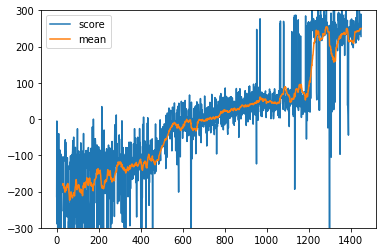

In [ ]:
## Earned score per episode  
window = 30
mean_arr = []
for i in range(len(score_arr) - window + 1):
    mean_arr.append(np.mean(np.array(score_arr[i:i+window])))
for i in range(window - 1):
    mean_arr.insert(0, np.nan)

plt.plot(score_arr, label ='score')
plt.plot(mean_arr, label ='mean')
plt.ylim([-300,300])
plt.legend(loc='upper left')

In [ ]:
## game play video
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make(game_name)) 
state = env.reset()
state_dim = len(state)
game_score = 0
score_arr2 = []
state_arr = []
for i in range(1000):
    if i == 0:
        stacked_state = np.concatenate((state, state, state, state, state, state, state, state), axis=0)
    else:
        stacked_state = np.roll(stacked_state,-state_dim,axis=0)        
        stacked_state[-state_dim:]=state
    with torch.no_grad():
        hs = agent.representation_network(torch.from_numpy(stacked_state).float().to(device))
        P, v = agent.prediction_network(hs)
        action = np.random.choice(np.arange(agent.action_space), p=P.detach().numpy())   
    if i %5==0:
        env.render()
    state, r, done, info = env.step(action.item())
    print(r, done, info)
    state_arr.append(state[0])
    game_score += r 
    score_arr2.append(game_score)
    if i %10==0: 
        print(game_score)
    if done:
        print('last frame number : ',i)
        print('score :', game_score)
        print(state_arr)
       
        break
env.reset()
env.display()

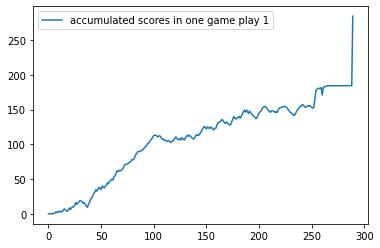

In [ ]:
plt.plot(score_arr2, label ='accumulated scores in one game play 1')
plt.legend(loc='upper left')

In [ ]:
## game play video 2
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make(game_name)) 
state = env.reset()
state_dim = len(state)
game_score = 0
score_arr2 = []
state_arr = []
for i in range(1000):
    if i == 0:
        stacked_state = np.concatenate((state, state, state, state, state, state, state, state), axis=0)
    else:
        stacked_state = np.roll(stacked_state,-state_dim,axis=0)        
        stacked_state[-state_dim:]=state
    with torch.no_grad():
        hs = agent.representation_network(torch.from_numpy(stacked_state).float().to(device))
        P, v = agent.prediction_network(hs)
        action = np.random.choice(np.arange(agent.action_space), p=P.detach().numpy())   
    if i %5==0:
        env.render()
    state, r, done, info = env.step(action.item())
    print(r, done, info)
    state_arr.append(state[0])
    game_score += r 
    score_arr2.append(game_score)
    if i %10==0: 
        print(game_score)
    if done:
        print('last frame number : ',i)
        print('score :', game_score)
        print(state_arr)
       
        break
env.reset()
env.display()

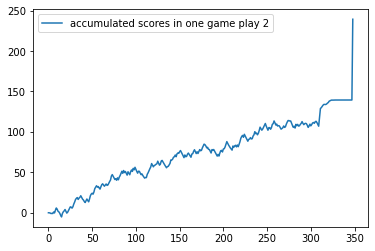

In [ ]:
plt.plot(score_arr2, label ='accumulated scores in one game play 2')
plt.legend(loc='upper left')

In [ ]:
## game play video 3
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make(game_name)) 
state = env.reset()
state_dim = len(state)
game_score = 0
score_arr2 = []
state_arr = []
for i in range(1000):
    if i == 0:
        stacked_state = np.concatenate((state, state, state, state, state, state, state, state), axis=0)
    else:
        stacked_state = np.roll(stacked_state,-state_dim,axis=0)        
        stacked_state[-state_dim:]=state
    with torch.no_grad():
        hs = agent.representation_network(torch.from_numpy(stacked_state).float().to(device))
        P, v = agent.prediction_network(hs)
        action = np.random.choice(np.arange(agent.action_space), p=P.detach().numpy())   
    if i %5==0:
        env.render()
    state, r, done, info = env.step(action.item())
    print(r, done, info)
    state_arr.append(state[0])
    game_score += r 
    score_arr2.append(game_score)
    if i %10==0: 
        print(game_score)
    if done:
        print('last frame number : ',i)
        print('score :', game_score)
        print(state_arr)
       
        break
env.reset()
env.display()

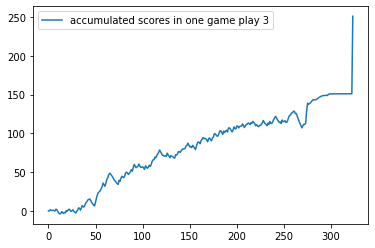

In [ ]:
plt.plot(score_arr2, label ='accumulated scores in one game play 3')
plt.legend(loc='upper left')